# Classification of field boundaries

Agricultural practice in the Peak District National Park (PDNP) has created an exten-sive palimpsest of field boundaries amongst other agricultural features such as dew ponds,
ridge and furrow, hedgerows and isolated trees. These features have been created for the most part over the last 600 years and add to the landscape character of the Peak District, which must be conserved and enhanced. However, the PDNP has lost significant lengths of field boundary features since designation.

To date, field boundary data have only been acquired through visual interpretation of aerial or satellite photography or site visits on a case-by-case basis. This requires con-
siderable resources, and therefore does not allow for monitoring boundary changes at a landscape scale. 

In this workbook, we use **1 km2 OS Ordnance Survey National Grid maps, 1940s-1970s — 1:10,560/1:10,000 scale** and the following workflow;

1) OCR and OS data create 'text' and 'urban' masks, 
2) MapReader to create 'non feature of interest' masks, 
3) Contour line mask & binarise the image
4) Probablistic Hough Transform detect boundary features from the 'masked images',
5) Create '1950's wall corridors'
6) Compare with present day Ordnace Survey data for an estinate of loss


In [6]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append('../scripts/')
import mapreader
from mapreader import PatchDataset
import cartopy
from torchvision import models
from torch import nn
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from dotenv import load_dotenv
from osdatahub import NGD
import numpy as np
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
from PIL import Image
import skimage.transform
import cv2
import pandas as pd
import keras_ocr

# Import custom classes **see https://github.com/pdnpa/cnn-boundaries/tree/main/scripts**
from geospatial_masking import Mask, Text_Mask, RasterPlotter, CombinedMask
import historic_wall_inference as hwi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) OCR, OS & Contour Mask

* Text mask
* OS mask

### Example workflow created

#### Example of keras-ocr text detection

Looking for /home/david/.keras-ocr/craft_mlt_25k.h5
Looking for /home/david/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 1s 7ms/step


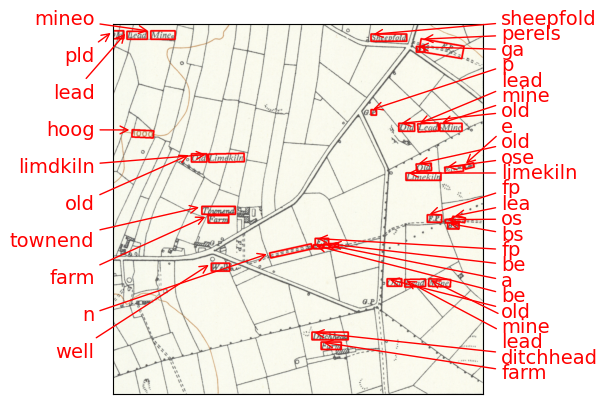

In [15]:
# example image
original_image_path = "../content/tifs/1k_tifs/SK1468.tif"


# Detect text in the image and annotate it
pipeline = keras_ocr.pipeline.Pipeline()
img = keras_ocr.tools.read(original_image_path)
prediction_groups = pipeline.recognize([img])
annotated_image = keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0])

#### Example of OS and Text Mask applied to .tif to be passed to MapReader

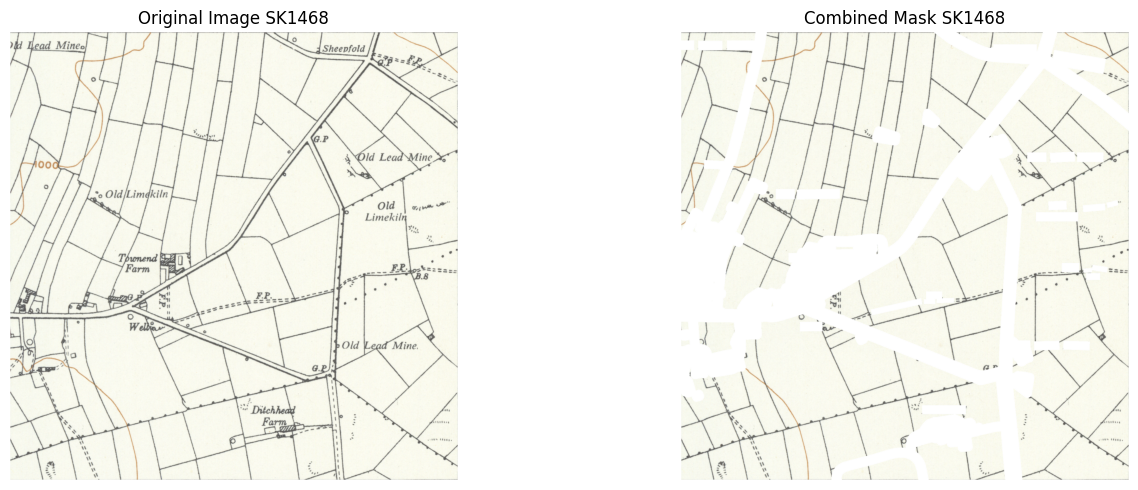

In [19]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub some data collections need admin

# example image
combined_mask_path = "../content/tifs/masked/SK1468_combined.tif"

# Read the images
original_image = Image.open(original_image_path)
combined_mask = Image.open(combined_mask_path)

# Plot the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image SK1468")
plt.axis('off')

# Plot the combined mask
plt.subplot(1, 2, 2)
plt.imshow(combined_mask)
plt.title("Combined Mask SK1468")
plt.axis('off')

plt.tight_layout()
plt.show()

## 2) MapReader Mask

#### Load .tif

In [9]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/13 [00:00<?, ?it/s]

#images: 13

#parents: 13
SK1868_combined.tif
SK1768_combined.tif
SK1070_combined.tif
SK1474_combined.tif
SK1570_combined.tif
SK1468_combined.tif
SK1469_combined.tif
SK1767_combined.tif
SK1668_combined.tif
SK1867_combined.tif
SK1476_combined.tif
...

#patches: 0



#### Patchify

In [10]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
#my_files.save_patches_as_geotiffs(crs='EPSG:27700')

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/13 [00:00<?, ?it/s]

../content/tifs/masked/SK1868_combined.tif
../content/tifs/masked/SK1768_combined.tif
../content/tifs/masked/SK1070_combined.tif
../content/tifs/masked/SK1474_combined.tif
../content/tifs/masked/SK1570_combined.tif
../content/tifs/masked/SK1468_combined.tif
../content/tifs/masked/SK1469_combined.tif
../content/tifs/masked/SK1767_combined.tif
../content/tifs/masked/SK1668_combined.tif
../content/tifs/masked/SK1867_combined.tif
../content/tifs/masked/SK1476_combined.tif
../content/tifs/masked/SK1678_combined.tif
../content/tifs/masked/SK1567_combined.tif


In [11]:
parent_list = my_files.list_parents()
patch_list = my_files.list_patches()

print(parent_list)
print(patch_list[0:5])  # too many to print them all!

['SK1868_combined.tif', 'SK1768_combined.tif', 'SK1070_combined.tif', 'SK1474_combined.tif', 'SK1570_combined.tif', 'SK1468_combined.tif', 'SK1469_combined.tif', 'SK1767_combined.tif', 'SK1668_combined.tif', 'SK1867_combined.tif', 'SK1476_combined.tif', 'SK1678_combined.tif', 'SK1567_combined.tif']
['patch-0-0-25-25-#SK1868_combined.tif#.png', 'patch-0-25-25-50-#SK1868_combined.tif#.png', 'patch-0-50-25-75-#SK1868_combined.tif#.png', 'patch-0-75-25-100-#SK1868_combined.tif#.png', 'patch-0-100-25-125-#SK1868_combined.tif#.png']


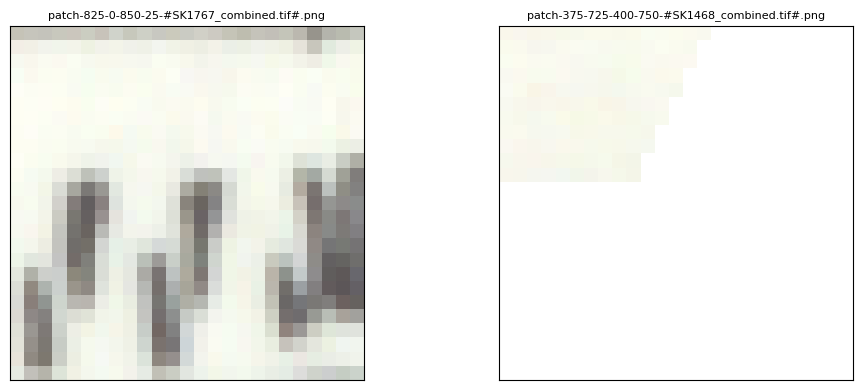

In [12]:
my_files.show_sample(num_samples=2, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

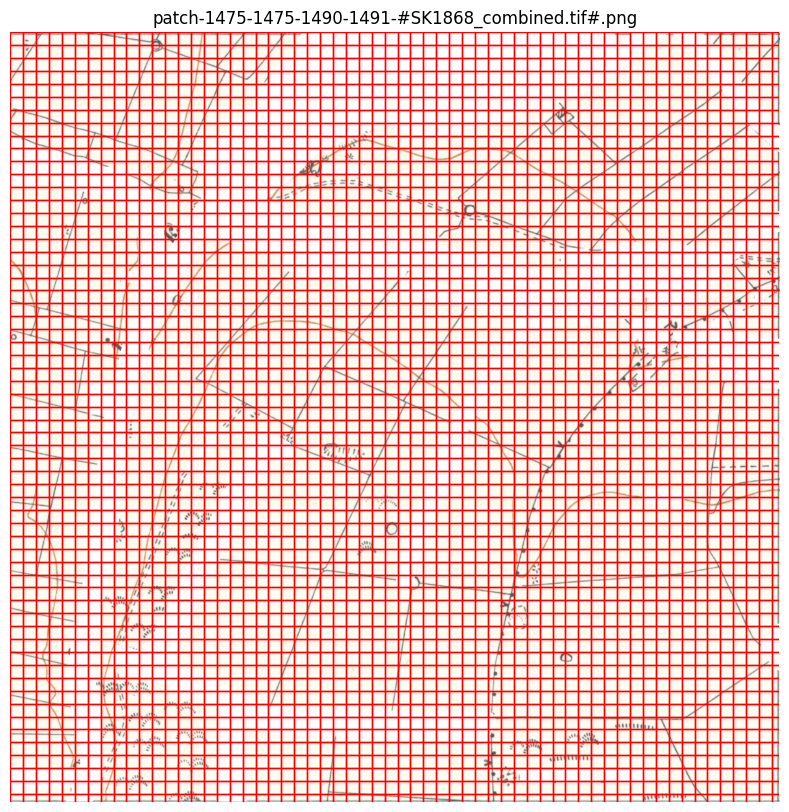

In [24]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[0])

In [13]:
my_files.calc_pixel_stats()
parent_df, patch_df = my_files.convert_images()
parent_df["url"]="fake_url"

  0%|          | 0/13 [00:00<?, ?it/s]

### Annotate

In [14]:
from mapreader import Annotator

annotator = Annotator(
    patch_df=patch_df,
    parent_df=parent_df,
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)

annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

[INFO] Loading existing patch annotations.


Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [15]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv'

#### Perpare training

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-03-01 16:28:18.934430: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 16:28:18.955775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 16:28:18.955798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 16:28:18.956607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 16:28:18.960706: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-03-01 16:28:19.810498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:28:19.836031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:28:19.836168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
#### Allow Memeory Growth ####

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth config before initializing GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Initialize the GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-01 16:28:29.633606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:28:29.633811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:28:29.633947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
import tensorflow as tf
print("GPU Name:", tf.test.gpu_device_name())
print("GPU Memory Growth:", tf.config.experimental.get_memory_growth(tf.config.list_physical_devices('GPU')[0]))

GPU Name: /device:GPU:0
GPU Memory Growth: True


2024-03-01 17:11:14.944774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 17:11:14.944948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 17:11:14.945054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
# Load and check annotations 

import pandas as pd

df = pd.read_csv(annotator.annotations_file, index_col=0)
df["image_id"]=df.index

from mapreader import AnnotationsLoader

annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   303

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  216
    - wall:  87



In [17]:
# view the data
annotated_images.annotations.head(2)

,label,image_path,parent_id,pixel_bounds,image_id,label_index
image_id,,,,,,
patch-100-550-125-575-#SK1070_combined.tif#.png,wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(100, 550, 125, 575)",patch-100-550-125-575-#SK1070_combined.tif#.png,0
patch-175-125-200-150-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(175, 125, 200, 150)",patch-175-125-200-150-#SK1070_combined.tif#.png,1


In [18]:
# label map
annotated_images.labels_map

{0: 'wall', 1: 'no_wall'}

In [19]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders()

[INFO] Creating datasets using default train/val/test split of 0.7:0.15:0.15 and default transformations.
[INFO] Number of annotations in each set:
    - train:   212
    - val:   45
    - test:   46
[INFO] Using default sampler.


### Train

In [20]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cuda:0
[INFO] Initializing model.
[INFO] Loaded "train" with 212 items.
[INFO] Loaded "val" with 45 items.
[INFO] Loaded "test" with 46 items.


In [21]:
# loss function
my_classifier.add_criterion("cross-entropy")
# optimizer 
my_classifier.initialize_optimizer()
# scheduler
my_classifier.initialize_scheduler()

[INFO] Using "CrossEntropyLoss()" as criterion.


In [22]:
import torch
print(torch.__version__)
import tensorflow as tf
print(tf.__version__)

2.2.1+cu121
2.15.0


In [23]:
# train with default 25 epochs
my_classifier.train()

[INFO] Each step will pass: ['train', 'val'].
2024-02-23 14:18:21 pop-os [INFO] train    -- 1/25 --     16/212 (  7.5% ) -- Loss: 0.698
2024-02-23 14:18:21 pop-os [INFO] train    -- 1/25 --     96/212 ( 45.3% ) -- Loss: 0.219
2024-02-23 14:18:21 pop-os [INFO] train    -- 1/25 --    176/212 ( 83.0% ) -- Loss: 0.546
2024-02-23 14:18:21 pop-os [INFO] train    -- 1/25 -- Loss: 0.573; F_macro: 62.35; R_macro: 65.09
2024-02-23 14:18:21 pop-os [INFO] val      -- 1/25 --      16/45 ( 35.6% ) -- Loss: 0.891
2024-02-23 14:18:21 pop-os [INFO] val      -- 1/25 -- Loss: 1.073; F_macro: 41.56; R_macro: 50.00

2024-02-23 14:18:21 pop-os [INFO] train    -- 2/25 --     16/212 (  7.5% ) -- Loss: 0.127
2024-02-23 14:18:22 pop-os [INFO] train    -- 2/25 --     96/212 ( 45.3% ) -- Loss: 0.233
2024-02-23 14:18:22 pop-os [INFO] train    -- 2/25 --    176/212 ( 83.0% ) -- Loss: 0.109
2024-02-23 14:18:22 pop-os [INFO] train    -- 2/25 -- Loss: 0.427; F_macro: 64.93; R_macro: 63.37
2024-02-23 14:18:22 pop-os [I

### Plot metrics

In [24]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

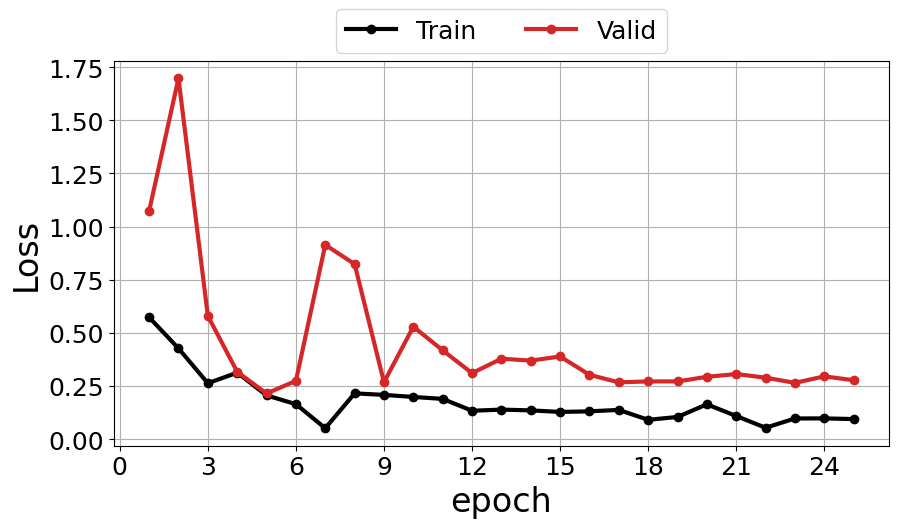

In [25]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Testing

In [26]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].
2024-02-23 14:19:28 pop-os [INFO] test     -- 26/26 --      16/46 ( 34.8% ) -- 
[INFO] Total time: 0m 0s


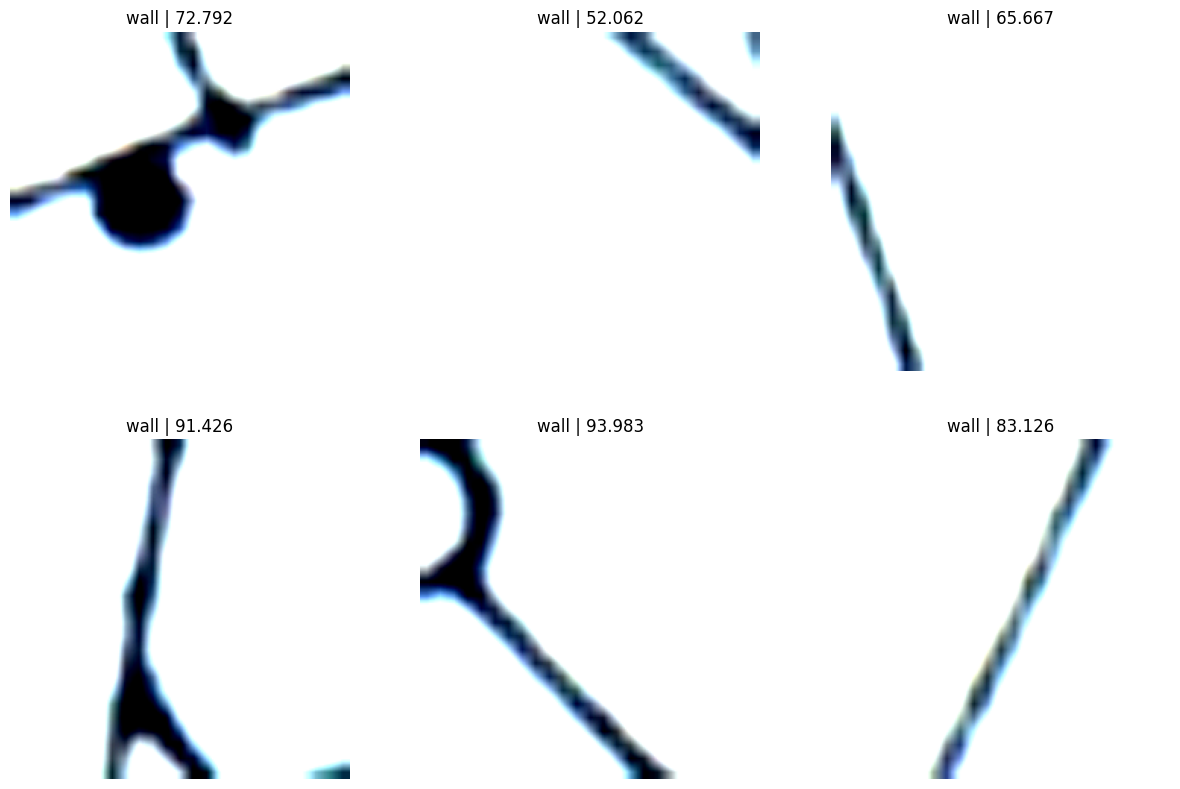

In [27]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

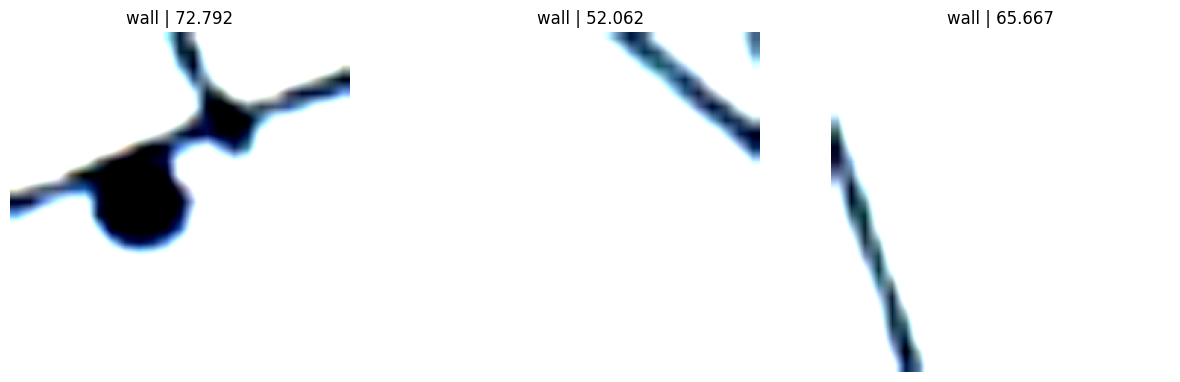

In [28]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall", max_conf=80)

In [29]:
my_classifier.calculate_add_metrics(
    y_true=my_classifier.orig_label,
    y_pred=my_classifier.pred_label,
    y_score=my_classifier.pred_conf,
    phase="test",
)

In [30]:
my_classifier.metrics["epoch_rocauc_macro_test"]

[3.0303030303030294]

### Save

In [31]:
my_classifier.save("../notebooks/models/test_5.pkl")

### Model Inference

In [35]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv".


In [36]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [37]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-02-23 14:22:05 pop-os [INFO] infer    -- 26/26 --     16/303 (  5.3% ) -- 
2024-02-23 14:22:05 pop-os [INFO] infer    -- 26/26 --     96/303 ( 31.7% ) -- 
2024-02-23 14:22:05 pop-os [INFO] infer    -- 26/26 --    176/303 ( 58.1% ) -- 
2024-02-23 14:22:05 pop-os [INFO] infer    -- 26/26 --    256/303 ( 84.5% ) -- 
[INFO] Total time: 0m 0s


### Add predictions to metadata and save

In [38]:
import numpy as np

infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [39]:
infer.patch_df.head(2)

,label,image_path,parent_id,pixel_bounds,predicted_label,pred,conf
image_id,,,,,,,
patch-100-550-125-575-#SK1070_combined.tif#.png,wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(100, 550, 125, 575)",wall,0,0.969184
patch-175-125-200-150-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(175, 125, 200, 150)",no_wall,1,0.942107


0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

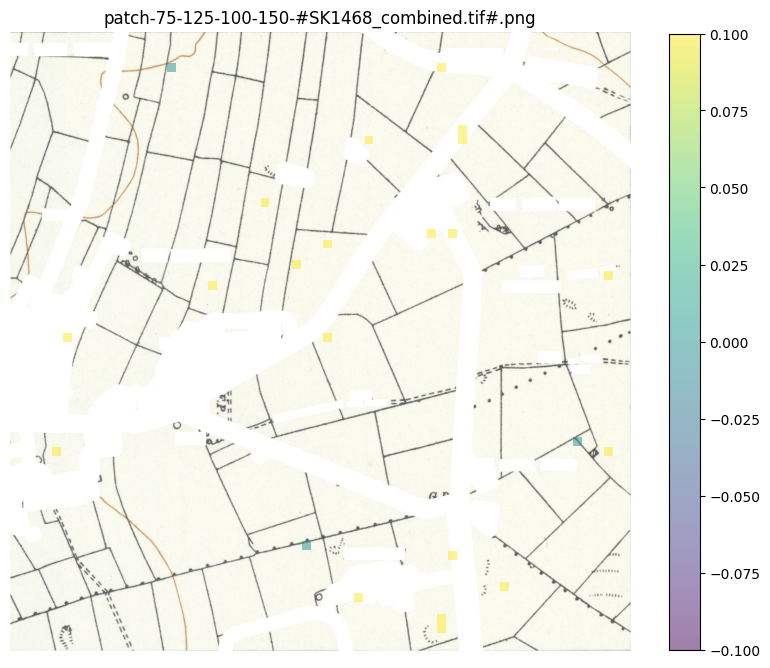

In [51]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[5], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [41]:
patch_df.reset_index(inplace=True, drop=False)

In [42]:
predictions = PatchDataset(patch_df, transform="test")

In [43]:
predictions

In [44]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(predictions, set_name="predictions")

In [45]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --   16/46800 (  0.0% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --   96/46800 (  0.2% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --  176/46800 (  0.4% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --  256/46800 (  0.5% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --  336/46800 (  0.7% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --  416/46800 (  0.9% ) -- 
2024-02-23 14:22:41 pop-os [INFO] predictions -- 26/26 --  496/46800 (  1.1% ) -- 
2024-02-23 14:22:42 pop-os [INFO] predictions -- 26/26 --  576/46800 (  1.2% ) -- 
2024-02-23 14:22:42 pop-os [INFO] predictions -- 26/26 --  656/46800 (  1.4% ) -- 
2024-02-23 14:22:42 pop-os [INFO] predictions -- 26/26 --  736/46800 (  1.6% ) -- 
2024-02-23 14:22:42 pop-os [INFO] predictions -- 26/26 --  816/46800 (  1.7% ) -- 
2024-02-23 14:22:42 pop-os [INFO] predicti

In [46]:
import numpy as np

predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

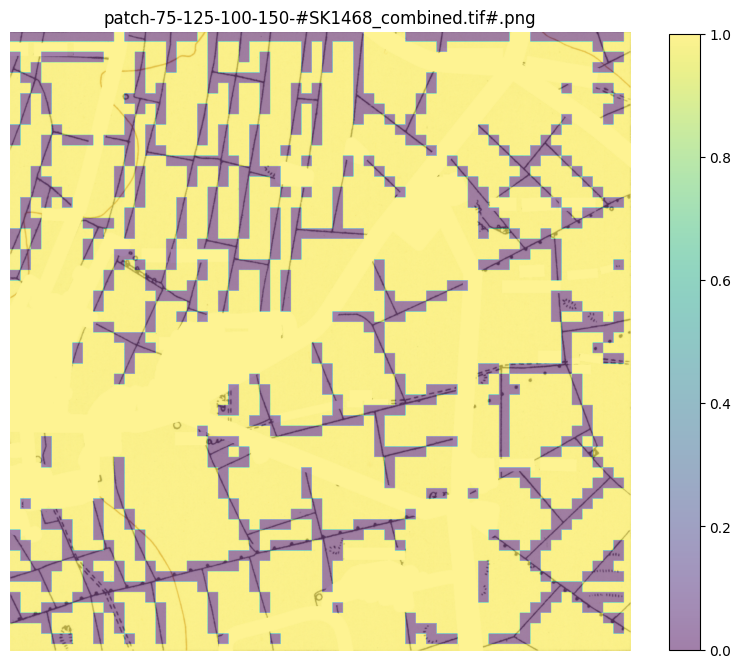

In [52]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

patch_df_predictions = predictions.patch_df
my_maps.add_metadata(patch_df_predictions, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[5], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

In [53]:
import geopandas as gpd

# change tuple columns to strings
for col in patch_df_predictions.columns:
    if isinstance(patch_df_predictions[col][0], tuple):
        patch_df_predictions[col] = patch_df_predictions[col].apply(str)

geo_patch_df = gpd.GeoDataFrame(patch_df_predictions, geometry="polygon", crs='EPSG:4326')
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [54]:
patch_df_predictions.to_csv("../content/predictions/predictions_patch_df.csv", sep=",")

## 3) Contour line mask

## 4) Probablistic Hough Transform

## 5) Create '1950's wall corridors'

## 6) Compare with 2024 Ordnance Survey data